<a href="https://colab.research.google.com/github/byunsy/financial-forecasting/blob/main/Financial_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Forecasting with LSTM and TensorFlow

## Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
!pip install -q finance-datareader
import FinanceDataReader as fdr

## Attain Financial Datasets

In [3]:
STOCK_CODE = '005930'
stock = fdr.DataReader(STOCK_CODE)

In [4]:
print(stock)

             Open   High    Low  Close    Volume    Change
Date                                                      
1997-02-06    924    935    898    930    140231       NaN
1997-02-10    930    958    924    959    105570  0.031183
1997-02-11    960    972    942    973    130180  0.014599
1997-02-12    967   1022    964   1001    241110  0.028777
1997-02-13   1004   1081   1004   1049    323720  0.047952
...           ...    ...    ...    ...       ...       ...
2021-01-13  89800  91200  89100  89700  36068848 -0.009934
2021-01-14  88700  90000  88700  89700  26393970  0.000000
2021-01-15  89800  91800  88000  88000  33431809 -0.018952
2021-01-18  86600  87300  84100  85000  43227951 -0.034091
2021-01-19  84500  88000  83600  87000  39714944  0.023529

[6000 rows x 6 columns]


We can attain a total of 6,000 data points from FDR.

## Data Visualizations

Text(0, 0.5, 'price')

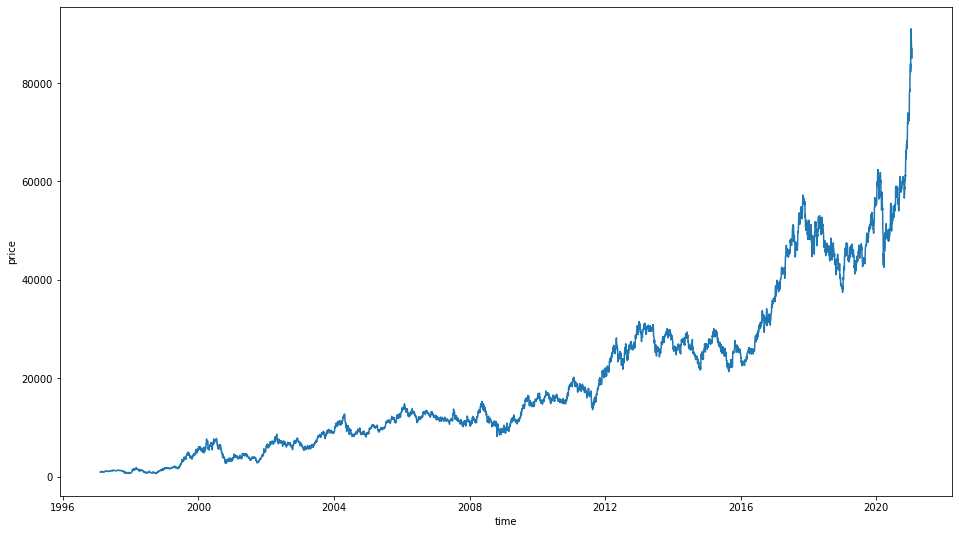

In [5]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

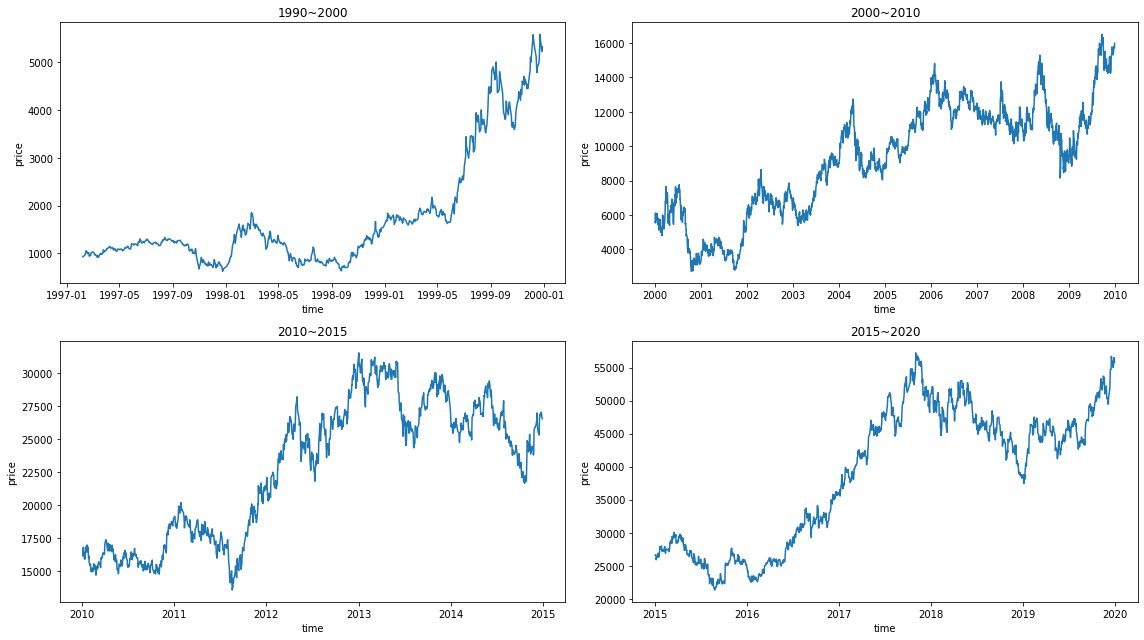

In [6]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)

for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
    
plt.tight_layout()
plt.show()

## Data Preprocessing

### Normalization


We can normalize the entire dataset using the MinMaxScaler method.

In [7]:
from sklearn.preprocessing import MinMaxScaler

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
scaled = MinMaxScaler().fit_transform(stock[scale_cols])

print(scaled)

[[0.01023256 0.00965909 0.01003352 0.00335277 0.00155284]
 [0.010299   0.00989669 0.01032402 0.00367366 0.00116902]
 [0.01063123 0.01004132 0.01052514 0.00382858 0.00144154]
 ...
 [0.9944629  0.94834711 0.98324022 0.96680424 0.37020512]
 [0.95902547 0.9018595  0.9396648  0.93360849 0.47868211]
 [0.93576966 0.90909091 0.93407821 0.95573899 0.43978104]]


In [8]:
df = pd.DataFrame(scaled, columns=scale_cols)
print(df)

          Open      High       Low     Close    Volume
0     0.010233  0.009659  0.010034  0.003353  0.001553
1     0.010299  0.009897  0.010324  0.003674  0.001169
2     0.010631  0.010041  0.010525  0.003829  0.001442
3     0.010709  0.010558  0.010771  0.004138  0.002670
4     0.011118  0.011167  0.011218  0.004670  0.003585
...        ...       ...       ...       ...       ...
5995  0.994463  0.942149  0.995531  0.985615  0.399406
5996  0.982281  0.929752  0.991061  0.985615  0.292272
5997  0.994463  0.948347  0.983240  0.966804  0.370205
5998  0.959025  0.901860  0.939665  0.933608  0.478682
5999  0.935770  0.909091  0.934078  0.955739  0.439781

[6000 rows x 5 columns]


Now we finally have a time-series data frame of scaled stock prices for the last 6,000 business days. 

### Split Testing and Training Datasets

**Note to self:**

For train_test_split, the first data param is for x variables (so we remove the 'Close' column) and the second is for the y varibles (hence we use the 'Close' column). 

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop(['Close'], axis=1), 
                                                    df['Close'], 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=False)

Let's see if we have successfully split the datasets. 

In [10]:
print(x_train.shape, y_train.shape)

(4800, 4) (4800,)


In [11]:
print(x_test.shape, y_test.shape)

(1200, 4) (1200,)


The datasets have been split into **8:2 ratio**, and we also notice that **x-datasets have 4 columns** for 'Open', 'High', 'Low', and 'Volume', and **y-datasets have just one column**, which is the target 'Close' column. 

## Create Sequential Datasets

In [12]:
import tensorflow as tf

We can create a function to conveniently create sequential datasets that we use to train a time-series dataset. 

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle):

    # add another dimension at the inner-most layer
    series = tf.expand_dims(series, axis=-1)

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size + 1))

    if shuffle:
        dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda w: (w[:-1], w[-1]))

    return dataset.batch(batch_size).prefetch(1)

In [14]:
# Set hyperparameters
WINDOW_SIZE=20
BATCH_SIZE=32

In [15]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data  = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

## Construct A Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = tf.keras.models.Sequential([
                                    
    # A single convolutional layer can be helpful.         
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           padding="causal",
                           activation="relu",
                           input_shape=[WINDOW_SIZE, 1]),

    # LSTM Layer
    tf.keras.layers.LSTM(16, activation='tanh'),

    # Dense Layers
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [18]:
loss = tf.keras.losses.Huber()
optm = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss=loss, optimizer=optm, metrics=['mse'])

In [19]:
# Earlystopping will stop the learning process when there are no
# ten consecutive improvements in the val_loss.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

# Create a checkpoint based on val_loss
checkpoint = tf.keras.callbacks.ModelCheckpoint("my_checkpoint.h5", 
                                               save_best_only=True)

## Train the Model

In [20]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=100, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
150/150 [==============================] - 5s 16ms/step - loss: 1.3826e-04 - mse: 2.7651e-04 - val_loss: 6.1997e-04 - val_mse: 0.0012
Epoch 2/100
150/150 [==============================] - 2s 12ms/step - loss: 1.1886e-05 - mse: 2.3772e-05 - val_loss: 5.1700e-04 - val_mse: 0.0010
Epoch 3/100
150/150 [==============================] - 2s 12ms/step - loss: 1.0368e-05 - mse: 2.0736e-05 - val_loss: 5.0569e-04 - val_mse: 0.0010
Epoch 4/100
150/150 [==============================] - 2s 12ms/step - loss: 1.0038e-05 - mse: 2.0075e-05 - val_loss: 4.4328e-04 - val_mse: 8.8656e-04
Epoch 5/100
150/150 [==============================] - 2s 13ms/step - loss: 9.8903e-06 - mse: 1.9781e-05 - val_loss: 4.3061e-04 - val_mse: 8.6122e-04
Epoch 6/100
150/150 [==============================] - 2s 12ms/step - loss: 1.0527e-05 - mse: 2.1053e-05 - val_loss: 5.3322e-04 - val_mse: 0.0011
Epoch 7/100
150/150 [==============================] - 2s 12ms/step - loss: 9.6072e-06 - mse: 1.9214e-05 - val_loss:

## Model Predictions

We load the saved model checkpoint to predict the test_data.

In [21]:
model = tf.keras.models.load_model("my_checkpoint.h5")
pred = model.predict(test_data)

In [22]:
print(pred.shape)

(1180, 1)


We see that we have 1,180 and this is because we don't use the last 20 data points to predict/forecast.  

Let's visualize our result.

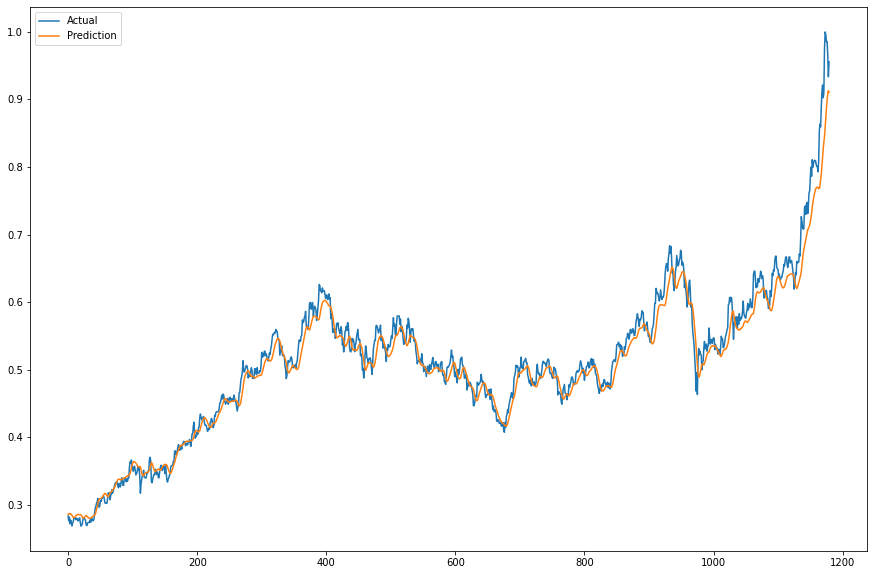

In [23]:
plt.figure(figsize=(15, 10))
plt.plot(np.asarray(y_test)[20:], label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()
plt.show()